# Dartboard and Simplex Diagrams

This notebook contains the code to generate various dartboard and simplex diagrams from https://arxiv.org/abs/2301.03962v1

In [27]:
from sklearn.base import clone
from sklearn.ensemble._base import _set_random_states
from scipy.stats.mstats import gmean
import numpy as np
import matplotlib.pyplot as plt
import decompose.plotting_utils as plotting_utils
from sklearn.ensemble import BaggingClassifier
import sys, os.path

import warnings
warnings.filterwarnings("ignore")
import matplotlib

# If LaTeX is not installed, comment this line
matplotlib.rcParams.update({"text.usetex": True})

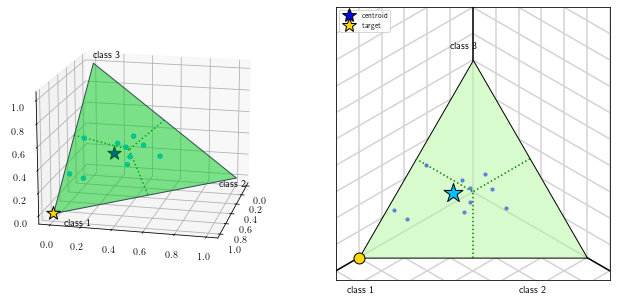

In [28]:

class PatchedBaggingClassifier(BaggingClassifier):
    """
    Patch for BaggingClassifier which allows for all models in the ensemble to have the same initialisation
    for their random state
    """

    def __init__(self,
                 base_estimator=None,
                 n_estimators=10, *,
                 max_samples=1.0,
                 max_features=1.0,
                 bootstrap=True,
                 bootstrap_features=False,
                 oob_score=False,
                 warm_start=False,
                 n_jobs=None,
                 random_state=None,
                 verbose=0):

        super().__init__(
            base_estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            bootstrap=bootstrap,
            bootstrap_features=bootstrap_features,
            oob_score=oob_score,
            warm_start=warm_start,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose)

    def _make_estimator(self, append=True, random_state=None):
        """Make and configure a copy of the `base_estimator_` attribute.

        Warning: This method should be used to properly instantiate new
        sub-estimators.
        """
        estimator = clone(self.base_estimator_)
        estimator.set_params(**{p: getattr(self, p)
                                for p in self.estimator_params})

        if random_state is not None:
            _set_random_states(estimator, np.random.RandomState(1))

        if append:
            self.estimators_.append(estimator)

        return estimator


# Testing with a random set of points
n=10
np.random.seed(0)
xs_orig = np.random.uniform(0, 1, n)
ys_orig = np.random.uniform(0, 1, n)
zs_orig = np.random.uniform(0, 1, n)
xs = xs_orig / (xs_orig + ys_orig + zs_orig)
ys = ys_orig / (xs_orig + ys_orig + zs_orig)
zs = zs_orig / (xs_orig + ys_orig + zs_orig)
centroid = np.array([5.5/13, 3.25/13, 4.25/13])
target = np.array([1, 0, 0])
points = [xs, ys, zs]
points = np.array(points).T

plotting_utils.plot_2d_and_3d_simplex(points, centroid, target=target, faux_3d=True, legend=True)
plt.show()


solver="sgd", activation="relu",
                      hidden_layer_sizes=(20),
                      tol=0., alpha=0, learning_rate_init=0.05,
                      max_iter=100, momentum=0.,
                      n_iter_no_change=10000


# High Variance, Low Bias

10% of labels are randomly re-assigned

In [29]:
# High Variance/Low bias
%matplotlib inline
import sklearn
from sklearn.neural_network import MLPClassifier
from decompose import CrossEntropy
from decompose import data_utils

ENSEMBLE_SIZE = 100
np.random.seed(0)
train_X, train_y, test_X, test_y = data_utils.load_standard_dataset("wine",
                                                                        frac_training=0.75,
                                                                        normalize_data=True,
                                                                        label_noise=0.1)
num_test = test_X.shape[0]


model = MLPClassifier(solver="sgd", activation="relu",
                      hidden_layer_sizes=(20),
                      tol=0., alpha=0, learning_rate_init=0.05,
                      max_iter=100, momentum=0.,
                      n_iter_no_change=10000 )

ensemble = BaggingClassifier(base_estimator=model, bootstrap=True, n_estimators=ENSEMBLE_SIZE)
ensemble.fit(train_X, train_y)


BaggingClassifier(base_estimator=MLPClassifier(alpha=0, hidden_layer_sizes=20,
                                               learning_rate_init=0.05,
                                               max_iter=100, momentum=0.0,
                                               n_iter_no_change=10000,
                                               solver='sgd', tol=0.0),
                  n_estimators=100)

[0.97239732 0.01341495 0.01418772]
0
[1. 0. 0.]


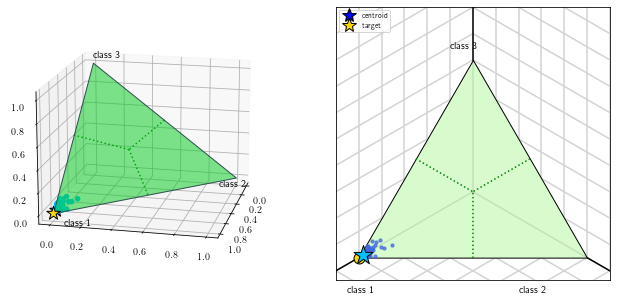

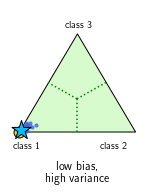

In [30]:
outputs = np.zeros([1, ENSEMBLE_SIZE, num_test, 3])
for idx, model_ in enumerate(ensemble.estimators_):
    outputs[0, idx, ...] = model_.predict_proba(test_X)

decomp = CrossEntropy(outputs, test_y)
centroids = decomp._inverse_generator_gradient(decomp.etas.mean(axis=(0,1)))

example_no = 1
centroid = centroids[example_no, ...]
points = outputs[0, :, example_no]
target = np.zeros(3)
print(centroid)
print(test_y[example_no])
target[test_y[example_no]] = 1
print(target)

plotting_utils.plot_2d_and_3d_simplex(points, centroid, faux_3d=True, target=target, legend=True)


fig, ax = plt.subplots()
fig.set_figheight(2.5)
fig.set_figwidth(2.5)
plotting_utils.plot_simplex_2d(points, centroid, axes=ax, faux_3d=False, target=target, legend=False)
plt.text(0.5, -.45, "low bias,\n high variance", ha="center", fontsize=12)


plt.axis("off")
plt.savefig(f"images/simplex_high_var_low_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()


# Low Variance/ Low Bias

Standard Setup, no label noise

In [31]:
%matplotlib inline
import sklearn
from sklearn.neural_network import MLPClassifier
from decompose import CrossEntropy

ENSEMBLE_SIZE = 100
np.random.seed(0)


model = MLPClassifier(solver="sgd", activation="relu",
                      hidden_layer_sizes=(20),
                      tol=0., alpha=0, learning_rate_init=0.05,
                      max_iter=100, momentum=0.,
                      n_iter_no_change=10000 )

ensemble = BaggingClassifier(base_estimator=model, bootstrap=True, n_estimators=ENSEMBLE_SIZE)
ensemble.fit(train_X, train_y)


BaggingClassifier(base_estimator=MLPClassifier(alpha=0, hidden_layer_sizes=20,
                                               learning_rate_init=0.05,
                                               max_iter=100, momentum=0.0,
                                               n_iter_no_change=10000,
                                               solver='sgd', tol=0.0),
                  n_estimators=100)

[0.97318237 0.01218531 0.01463233]
0
[1. 0. 0.]


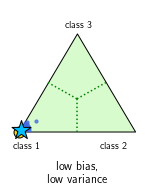

In [32]:
# Low bias/ low variance
outputs = np.zeros([1, ENSEMBLE_SIZE, num_test, 3])
for idx, model_ in enumerate(ensemble.estimators_):
    outputs[0, idx, ...] = model_.predict_proba(test_X)

decomp = CrossEntropy(outputs, test_y)
centroids = decomp._inverse_generator_gradient(decomp.etas.mean(axis=(0,1)))

example_no = 1
centroid = centroids[example_no, ...]
points = outputs[0, :, example_no]
target = np.zeros(3)
print(centroid)
print(test_y[example_no])
target[test_y[example_no]] = 1
print(target)


fig, ax = plt.subplots()
fig.set_figheight(2.5)
fig.set_figwidth(2.5)
plotting_utils.plot_simplex_2d(points, centroid, axes=ax, faux_3d=False, target=target, legend=False)
plt.text(0.5, -.45, "low bias,\n low variance", ha="center", fontsize=12)

plt.axis("off")
plt.savefig(f"images/simplex_low_var_low_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()

# High Variance/ High Bias

Standard setup, but with only 10 iterations so very little convergence

In [33]:
%matplotlib inline
import sklearn
from sklearn.neural_network import MLPClassifier
from decompose import CrossEntropy

ENSEMBLE_SIZE = 100
np.random.seed(0)
num_test = test_X.shape[0]


model = MLPClassifier(solver="sgd", activation="relu",
                      hidden_layer_sizes=(20),
                      tol=0., alpha=0, learning_rate_init=0.05,
                      max_iter=10, momentum=0.,
                      n_iter_no_change=10000 )

ensemble = BaggingClassifier(base_estimator=model, bootstrap=True, n_estimators=ENSEMBLE_SIZE)
ensemble.fit(train_X, train_y)


BaggingClassifier(base_estimator=MLPClassifier(alpha=0, hidden_layer_sizes=20,
                                               learning_rate_init=0.05,
                                               max_iter=10, momentum=0.0,
                                               n_iter_no_change=10000,
                                               solver='sgd', tol=0.0),
                  n_estimators=100)

[0.65526105 0.18602022 0.15871873]
0
[1. 0. 0.]


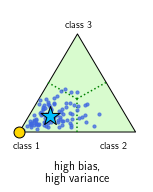

In [34]:
outputs = np.zeros([1, ENSEMBLE_SIZE, num_test, 3])
for idx, model_ in enumerate(ensemble.estimators_):
    outputs[0, idx, ...] = model_.predict_proba(test_X)

decomp = CrossEntropy(outputs, test_y)
centroids = decomp._inverse_generator_gradient(decomp.etas.mean(axis=(0,1)))

example_no = 1
centroid = centroids[example_no, ...]
points = outputs[0, :, example_no]
target = np.zeros(3)
print(centroid)
print(test_y[example_no])
target[test_y[example_no]] = 1
print(target)


fig, ax = plt.subplots()
fig.set_figheight(2.5)
fig.set_figwidth(2.5)
plotting_utils.plot_simplex_2d(points, centroid, axes=ax, faux_3d=False, target=target, legend=False)
plt.text(0.5, -.45, "high bias,\n high variance", ha="center", fontsize=12)

plt.axis("off")
plt.savefig(f"images/simplex_high_var_high_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()


# Low Variance, High Bias

Few training iterations and same initialisation for each ensemble member

In [35]:
%matplotlib inline
import sklearn
from sklearn.neural_network import MLPClassifier

ENSEMBLE_SIZE = 100
np.random.seed(0)

num_test = test_X.shape[0]


model = MLPClassifier(solver="sgd", activation="relu",
                      hidden_layer_sizes=(20),
                      tol=0., alpha=0, learning_rate_init=0.05,
                      max_iter=10, momentum=0.,
                      n_iter_no_change=10000 )

ensemble = PatchedBaggingClassifier(base_estimator=model, bootstrap=True, n_estimators=ENSEMBLE_SIZE,
                                    random_state=1)
ensemble.fit(train_X, train_y)


PatchedBaggingClassifier(base_estimator=MLPClassifier(alpha=0,
                                                      hidden_layer_sizes=20,
                                                      learning_rate_init=0.05,
                                                      max_iter=10, momentum=0.0,
                                                      n_iter_no_change=10000,
                                                      solver='sgd', tol=0.0),
                         n_estimators=100, random_state=1)

[0.71337102 0.15251163 0.13411735]
0
[1. 0. 0.]


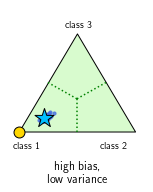

In [39]:

import importlib
importlib.reload(plotting_utils)

outputs = np.zeros([1, ENSEMBLE_SIZE, num_test, 3])
for idx, model_ in enumerate(ensemble.estimators_):
    outputs[0, idx, ...] = model_.predict_proba(test_X)

decomp = CrossEntropy(outputs, test_y)
centroids = decomp._inverse_generator_gradient(decomp.etas.mean(axis=(0,1)))

example_no = 1
centroid = centroids[example_no, ...]
points = outputs[0, :, example_no]
target = np.zeros(3)
print(centroid)
print(test_y[example_no])
target[test_y[example_no]] = 1
print(target)

fig, ax = plt.subplots()
fig.set_figheight(2.5)
fig.set_figwidth(2.5)
plotting_utils.plot_simplex_2d(points, centroid, axes=ax, faux_3d=False, target=target, legend=False)
plt.text(0.5, -.45, "high bias,\n low variance", ha="center", fontsize=12)

plt.axis("off")
plt.savefig(f"images/simplex_low_var_high_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()


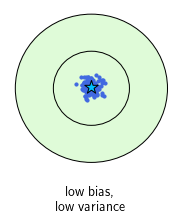

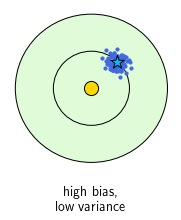

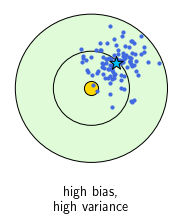

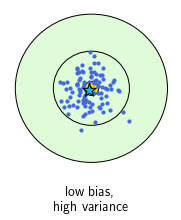

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
importlib.reload(plotting_utils)
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection


np.random.seed(0)
points = np.random.normal(0, 0.075, [100, 2])

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
plt.text(0, -1.65, "low bias,\n low variance", ha="center", fontsize=14)
plotting_utils.plot_dartboard(points, ax)
plt.axis("off")
plt.savefig(f"images/dartboard_low_var_low_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()


points = np.random.normal(.35, 0.075, [100, 2])

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
plotting_utils.plot_dartboard(points, ax)
plt.axis("off")
plt.text(0, -1.65, "high bias,\n low variance", ha="center", fontsize=14)
plt.savefig(f"images/dartboard_low_var_high_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()


points = np.random.normal(.35, 0.2, [100, 2])

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
plotting_utils.plot_dartboard(points, ax)
plt.axis("off")
plt.text(0, -1.65, "high bias,\n high variance", ha="center", fontsize=14)
plt.savefig(f"images/dartboard_high_var_high_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()

points = np.random.normal(0., 0.2, [100, 2])

fig, ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(3)
plotting_utils.plot_dartboard(points, ax)
plt.axis("off")
plt.text(0, -1.65, "low bias,\n high variance", ha="center", fontsize=14)
plt.savefig(f"images/dartboard_high_var_low_bias.svg", bbox_inches="tight", pad_inches=0)
plt.show()

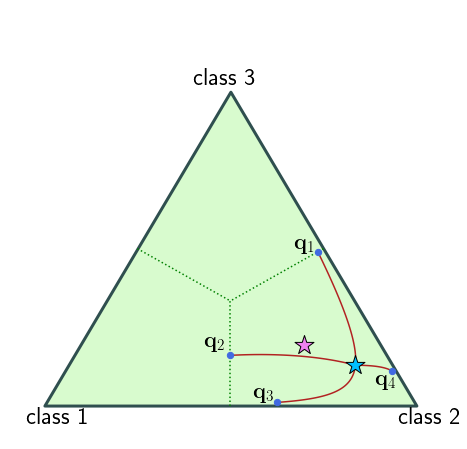

In [41]:

import decompose.plotting_utils as plotting_utils
import numpy as np

def create_geodesic_curve(begin_point, end_point):
    begin_point = np.log(np.divide(begin_point, begin_point[-1]))
    end_point   = np.log(np.divide(end_point, end_point[-1]))

    step_size = 0.01
    range_ = np.arange(0, 1 + step_size, step_size)
    line_points = np.reshape(begin_point, ([3,1])) * range_ + np.reshape(end_point, [3,1]) * (1 - range_)

    line_points = np.divide( np.exp(line_points), np.sum(np.exp(line_points), axis=0) )
    return line_points.T

def add_lines(ax, lines, **kwargs):
    for line in lines:
        projected_line = plotting_utils._project_onto_simplex(line)
        ax.plot(projected_line[:, 0], projected_line[:, 1], **kwargs)


points = np.array([[0.01, 0.88, 0.11],
                   [0.37, 0.62, 0.01],
                   [0.42, 0.42, 0.16],
                   [0.02, 0.49, 0.49]])

geometric_mean = gmean(points) / sum(gmean(points))
arithmetic_mean = np.mean(points, axis=0)

fig = plt.figure(figsize=(8, 8), frameon=False)
ax = plt.gca()
fig.set_size_inches(8, 8)
# draw_simplex(ax)


ax.text(0.67, 0.43, "$\mathbf{q}_1$", size=22)
ax.text(0.43, 0.16, "$\mathbf{q}_2$", size=22)
ax.text(0.56, 0.02, "$\mathbf{q}_3$", size=22)
ax.text(0.89, 0.055, "$\mathbf{q}_4$", size=22)


ax.text(-0.05, -0.05, "class 1", size=24)
ax.text(0.95, -0.05, "class 2", size=24)
ax.text(0.4, np.sqrt(3) / 2 + 0.02, "class 3", size=24)

plotting_utils.plot_simplex_2d(points, geometric_mean, axes=ax, legend=False, green_edges=True,
                               point_kwargs={"s" : 40, "alpha" : 1}, show_text=False)

projected = plotting_utils._project_onto_simplex(np.array([geometric_mean]))

projected = plotting_utils._project_onto_simplex(np.array([arithmetic_mean]))
plt.scatter(projected[:,0], projected[:,1], marker="*", color="violet", edgecolors="black", s=400, alpha=1., zorder=10)
            #color='green', s=75, marker='x')

lines = []
for point in points:
    lines.append(create_geodesic_curve(point, geometric_mean))

add_lines(ax, lines, color="firebrick", zorder=1)
plt.axis("off")
plt.savefig("images/centroid_simplex.svg")